In [519]:
# Custom round robin

import random
import pandas as pd
from itertools import combinations, chain

import matplotlib.pyplot as plt
import numpy as np


In [520]:
countries = [
    "Spain", "Argentina", "France", "England", "Brazil", "Germany", "Portugal", "Netherlands",
    "Colombia", "Uruguay", "Italy", "Croatia", "Ecuador", "Japan", "Denmark", "Belgium", "Serbia", "Turkey",
    "Austria", "Greece"
]

pool1 = ["Spain", "Argentina", "France", "England", "Brazil"]
pool2 = ["Germany", "Portugal", "Netherlands", "Colombia", "Uruguay"]
pool3 = ["Italy", "Croatia", "Ecuador", "Japan", "Denmark"]
pool4 = ["Belgium", "Serbia", "Turkey", "Austria", "Greece"]

countriesrs = {
    "Spain": 2150,
    "Argentina": 2140,
    "France": 2031,
    "England": 2012,
    "Brazil": 1994,
    "Germany": 1988,
    "Portugal": 1988,
    "Netherlands": 1967,
    "Colombia": 1953,
    "Uruguay": 1922,
    "Italy": 1914,
    "Croatia": 1912,
    "Ecuador": 1911,
    "Japan": 1875,
    "Denmark": 1862,
    "Belgium": 1844,
    "Serbia": 1844,
    "Turkey": 1837,
    "Austria": 1837,
    "Greece": 1830
}

countriesratings = countriesrs

for country in countriesrs.keys():
    rating = countriesrs[country]
    
    countriesratings[country] = (rating - 1830)/(2150-1830)
print(countriesratings)

{'Spain': 1.0, 'Argentina': 0.96875, 'France': 0.628125, 'England': 0.56875, 'Brazil': 0.5125, 'Germany': 0.49375, 'Portugal': 0.49375, 'Netherlands': 0.428125, 'Colombia': 0.384375, 'Uruguay': 0.2875, 'Italy': 0.2625, 'Croatia': 0.25625, 'Ecuador': 0.253125, 'Japan': 0.140625, 'Denmark': 0.1, 'Belgium': 0.04375, 'Serbia': 0.04375, 'Turkey': 0.021875, 'Austria': 0.021875, 'Greece': 0.0}


In [521]:
def simulate_match(country1, country2):
    # Randomly generate results: win, loss, or draw
    # result = random.choice(['win', 'loss', 'draw'])
    
    rating1 = countriesratings[country1]
    rating2 = countriesratings[country2]
    
    percent1 = rating1 / (rating1 + rating2)
    percent2 = rating2 / (rating1 + rating2)
    
    if random.random() < percent1:
        result = 'win'
    else:
        result = 'loss'
    
    if result == 'win':
        return country1, 3, country2, 0  # country1 wins, gets 3 points, country2 gets 0
    elif result == 'loss':
        return country1, 0, country2, 3  # country2 wins, gets 3 points, country1 gets 0
    else:
        return country1, 1, country2, 1  # Draw, both get 1 point each

In [522]:
def init_standings(teams):
    return {team: {'wins': 0, 'losses': 0, 'draws': 0, 'points': 0} for team in teams}

In [523]:

def round_robin(teams):
    standings = init_standings(teams)
    for team1, team2 in combinations(teams, 2):
        t1, p1, t2, p2 = simulate_match(team1, team2)
        standings[t1]['points'] += p1
        standings[t2]['points'] += p2
        if p1 == 3:
            standings[t1]['wins'] += 1
            standings[t2]['losses'] += 1
        elif p2 == 3:
            standings[t2]['wins'] += 1
            standings[t1]['losses'] += 1
        else:
            standings[t1]['draws'] += 1
            standings[t2]['draws'] += 1
    return standings


In [524]:

def sort_standings(standings):
    df = pd.DataFrame(standings).T
    df = df.sort_values(by=['points', 'wins'], ascending=False)
    return df

In [525]:

def simulate_knockout(teams):
    random.shuffle(teams)
    quarter_finalists = teams
    semi_finalists = []

    # Quarterfinals
    for i in range(0, 8, 2):
        team1, team2 = quarter_finalists[i], quarter_finalists[i+1]
        winner = simulate_match(team1, team2)[0 if random.random() < (countriesratings[team1] / (countriesratings[team1] + countriesratings[team2])) else 2]
        semi_finalists.append(winner)

    # Semifinals
    finalists = []
    for i in range(0, 4, 2):
        team1, team2 = semi_finalists[i], semi_finalists[i+1]
        winner = simulate_match(team1, team2)[0 if random.random() < (countriesratings[team1] / (countriesratings[team1] + countriesratings[team2])) else 2]
        finalists.append(winner)

    # Final
    final_winner = simulate_match(finalists[0], finalists[1])[0 if random.random() < (countriesratings[team1] / (countriesratings[team1] + countriesratings[team2])) else 2]
    
    return {
        "Quarterfinalists": quarter_finalists,
        "Semifinalists": semi_finalists,
        "Finalists": finalists,
        "Winner": final_winner
    }


{'Spain': 177, 'Argentina': 185, 'France': 70, 'England': 37, 'Brazil': 35, 'Germany': 113, 'Portugal': 88, 'Netherlands': 59, 'Colombia': 39, 'Uruguay': 15, 'Italy': 60, 'Croatia': 53, 'Ecuador': 47, 'Japan': 8, 'Denmark': 2, 'Belgium': 6, 'Serbia': 6, 'Turkey': 0, 'Austria': 0, 'Greece': 0}


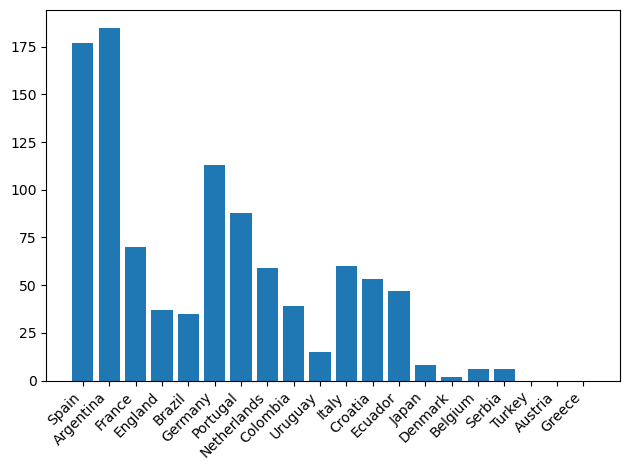

In [526]:
pools = {
    i+1: countries[i*5:(i+1)*5] for i in range(4)
}

winners = {country: 0 for country in countries}

for i in range(1000):
    # Step 2: Round robin in each pool
    pool_results = {}
    top_2_from_each_pool = []
    rest_teams = []

    for pool_name, teams in pools.items():
        standings = round_robin(teams)
        pool_results[pool_name] = sort_standings(standings)
        top_2 = list(pool_results[pool_name].index[:2])
        rest = list(pool_results[pool_name].index[2:])
        top_2_from_each_pool.extend(top_2)
        rest_teams.extend(rest)

    # Step 3: Knockout Stage
    knockout_results = simulate_knockout(top_2_from_each_pool)

    # Step 4: Consolation Round Robin for remaining 12 teams
    consolation_standings = round_robin(rest_teams)
    consolation_df = sort_standings(consolation_standings)

    # Step 5: Display Results
    # Pool Results
    # for pool_name, df in pool_results.items():
    #     print(f"\n{pool_name} Standings:\n", df)

    # # Knockout
    # print("\nKnockout Results:")
    # for stage, teams in knockout_results.items():
    #     print(f"{stage}: {teams}")

    # # Consolation League Standings
    # print("\nConsolation League Standings:")
    # print(consolation_df)
    
    winners[knockout_results['Winner']] += 1

print(winners)

names = list(winners.keys())
values = list(winners.values())

plt.bar(names, values)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels and align them to the right for better visibility
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()